# Declaration of Originality

![image.png](attachment:image.png)

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Tan Tek Yong (2404984C)
* Tutorial Group                : PC03
* Tutor						    : Ruchir Srivastsava
* Submission Date               : 11 Feb 2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

The following libraries are used for data handling, visualisation, modelling, and evaluation (as taught in class).

In [1]:
# Data handling
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt

# Train/test split + tuning
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV

# Pre-processing (step-by-step, no Pipeline)
from sklearn.preprocessing import StandardScaler

# Models (classification)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Metrics (multiple metrics + confusion matrix)
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report
)

# Save model for Streamlit deployment
import joblib

# Matplotlib default sizing (optional)
plt.rcParams["figure.figsize"] = (8, 5)


# 1. Business Understanding

**What is churn?**  
Customer **churn** means a customer stops using or cancels the service.

**Problem:** Churn reduces recurring revenue. Retaining customers is usually cheaper than acquiring new ones.  
**Goal:** Predict whether a customer will churn (`Yes/No`) so the company can prioritise retention actions (e.g., targeted promotions, contract upgrades, support outreach).

**ML task:** Supervised **binary classification** (target = `Churn`).  
**Business focus:** Missing a true churner (false negative) can lead to revenue loss, so we will evaluate multiple metrics and select a primary metric aligned with this objective.


Because churn is imbalanced, accuracy can be inflated by predicting “No” for most customers.
In churn prediction, a false negative (missed churner) is costly because the customer is lost.
Therefore, Recall for the churn class is selected as the primary metric, while Precision and F1
are used as secondary metrics to ensure the model does not over-flag churn unnecessarily.
ROC-AUC and PR-AUC are included to evaluate the model’s ranking ability across thresholds.


# 2. Data Understanding

Load the dataset, inspect schema, check target balance, and identify data quality issues (missing values / wrong data types).

In [2]:
# 2.1 Load dataset
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Basic shape check
print("Rows, Columns:", df.shape)

# Preview a few rows to understand columns
df.head()


Rows, Columns: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# 2.2 Data types and missing values
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Missing values count (top 10)
df.isna().sum().sort_values(ascending=False).head(10)


customerID          0
DeviceProtection    0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
dtype: int64

**Observation:**  
- `customerID` is an identifier (not predictive) and should be removed before modelling.  
- `TotalCharges` may be stored as text due to blank spaces; it must be converted to numeric.  
- The target `Churn` is often imbalanced, so accuracy alone is not sufficient.


# 3. Data Cleaning & Preparation

We follow the step-by-step approach taught in class (no Pipeline):
1) Fix data types
2) Handle missing values
3) Encode target and features
4) Train-test split (stratified)
5) Scale numeric features (fit on train, transform train & test)

`TotalCharges` should be numeric, but in this dataset it is sometimes stored as text
due to blank spaces. These blanks must be converted to NaN and handled.

Reason:
- ML algorithms require numeric values for numeric features
- Leaving text values will break scaling and model training

In [ ]:
# 3.1 Fix TotalCharges data type
# Convert to numeric; invalid values (e.g., blank strings) become NaN.
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# This shows the scale of the issue
print("TotalCharges NaN after conversion:", df["TotalCharges"].isna().sum())


TotalCharges NaN after conversion: 11


In [ ]:
# 3.2 Handle missing values

# Median is preferred because charges may contain extreme values
df["TotalCharges"] = df["TotalCharges"].fillna(df["TotalCharges"].median())

# Confirm no missing remains
df["TotalCharges"].isna().sum()


np.int64(0)

# 4. Exploratory Data Analysis (EDA)

EDA is used to:
- Understand class distribution (churn imbalance)
- Inspect feature distributions
- **Point out outliers directly on plots** (as required)
- Identify features that may relate to churn


If churn is imbalanced, accuracy alone can be misleading, so additional metrics
(precision, recall, F1, ROC-AUC, PR-AUC) are needed for evaluation.

In [7]:
# 4.1 Target distribution (Churn)
df["Churn"].value_counts()


Churn
No     5174
Yes    1869
Name: count, dtype: int64

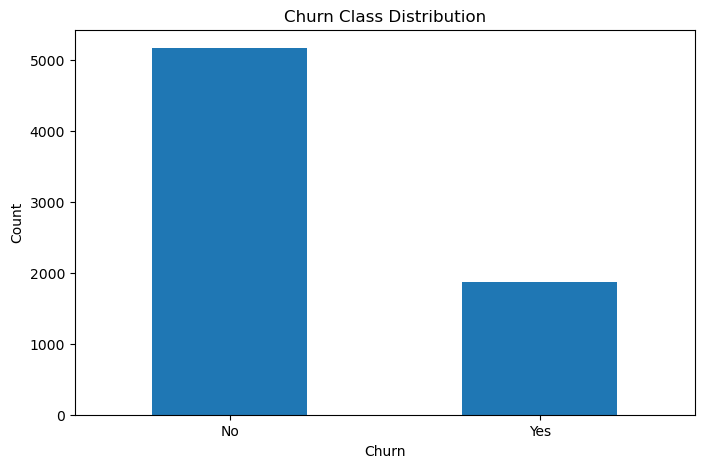

Churn
No     73.46
Yes    26.54
Name: proportion, dtype: float64

In [8]:
df["Churn"].value_counts().plot(kind="bar")
plt.title("Churn Class Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.show()

# Show percentage distribution for clarity
(df["Churn"].value_counts(normalize=True) * 100).round(2)


**Interpretation:**
Churn is not evenly distributed (more "No" than "Yes").  
Therefore, accuracy alone is not sufficient.  
A model can achieve high accuracy by predicting “No” most of the time.

Hence, recall and F1-score for the churn class (Yes) are important.


## 4.2 Distributions + outlier callouts

Histograms show how values are distributed and whether there is a long tail.
A long tail often indicates outliers.

Instead of only computing IQR, the plot is annotated to explicitly point out
the low-frequency tail region (outlier area) to meet the lecturer’s requirement.

For telco billing, high charges may represent valid premium customers, so outliers are not automatically removed unless they are clear data errors.


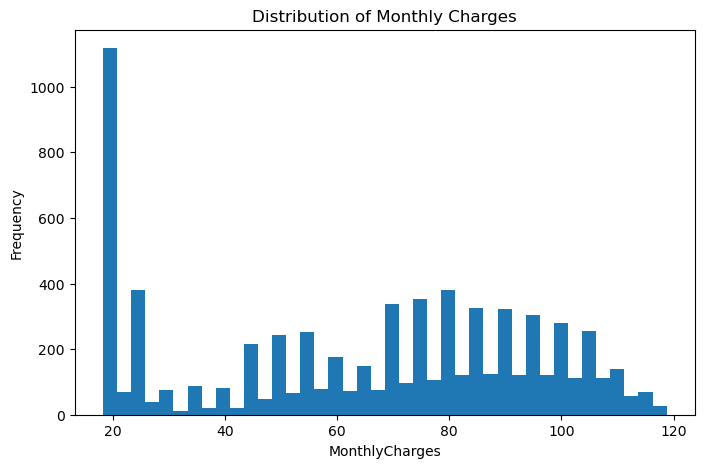

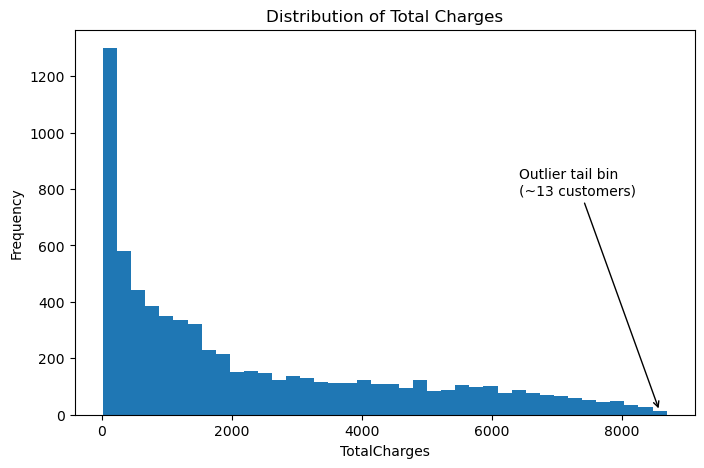

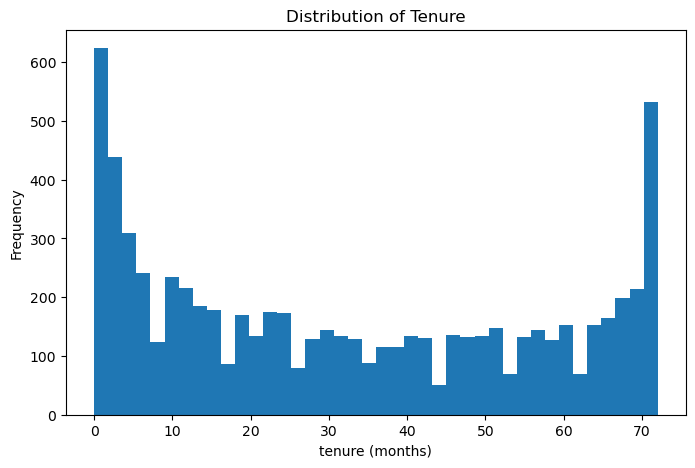

In [20]:
def hist_with_outlier_callout(series, bins=40, title="", xlabel=""):
    """Plot a histogram and annotate a low-frequency tail bin as a potential outlier region."""
    s = series.dropna()

    # Histogram counts (for outlier callout text)
    counts, edges = np.histogram(s, bins=bins)
    centers = (edges[:-1] + edges[1:]) / 2

    plt.figure(figsize=(8, 5))
    plt.hist(s, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frequency")

    # Heuristic: choose a right-tail bin (above 90th percentile) with low frequency
    max_c = counts.max()
    tail_x = np.quantile(s, 0.90)

    candidate = np.where((centers > tail_x) & (counts > 0) & (counts <= max_c * 0.02))[0]

    if len(candidate) > 0:
        i = candidate[-1]  # farthest right tail bin
        x = centers[i]
        y = counts[i]

        plt.annotate(
            f"Outlier tail bin\n(~{int(y)} customers)",
            xy=(x, y),
            xytext=(x - (edges[-1] - edges[0]) * 0.25, max_c * 0.6),
            arrowprops=dict(arrowstyle="->")
        )

    plt.show()


# Plot distributions + outlier callouts
hist_with_outlier_callout(df["MonthlyCharges"], bins=40,
                          title="Distribution of Monthly Charges",
                          xlabel="MonthlyCharges")

hist_with_outlier_callout(df["TotalCharges"], bins=40,
                          title="Distribution of Total Charges",
                          xlabel="TotalCharges")

hist_with_outlier_callout(df["tenure"], bins=40,
                          title="Distribution of Tenure",
                          xlabel="tenure (months)")


**Outlier interpretation (example):**  
If the histogram highlights a right-tail bin with very low frequency (e.g., ~20 customers), it is treated as a potential outlier region.  
However, these customers may represent valid high-value customers (premium services), so the values are **kept** unless they are confirmed as errors.


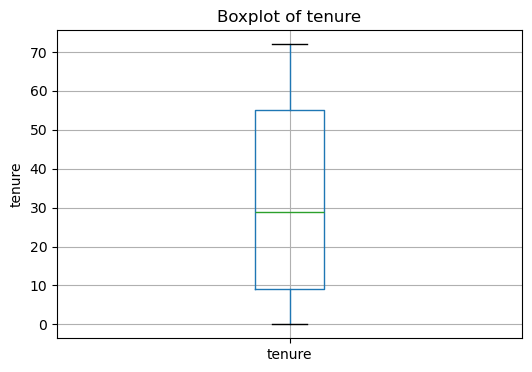

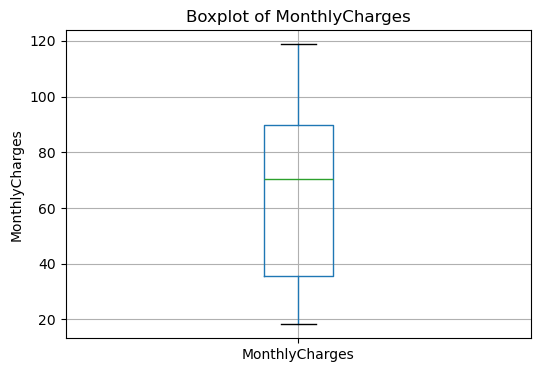

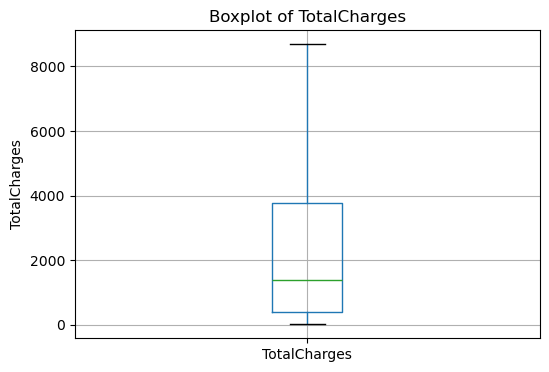

In [21]:
# Boxplots (supports outlier spotting)
for col in ["tenure", "MonthlyCharges", "TotalCharges"]:
    plt.figure(figsize=(6, 4))
    df.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    plt.ylabel(col)
    plt.show()


## 4.3 Relationship to churn
We examine churn rates by important categorical features to see which features might be predictive.

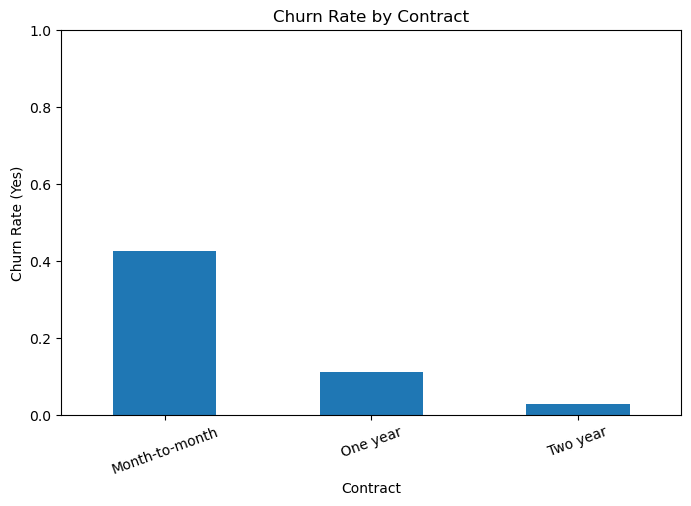

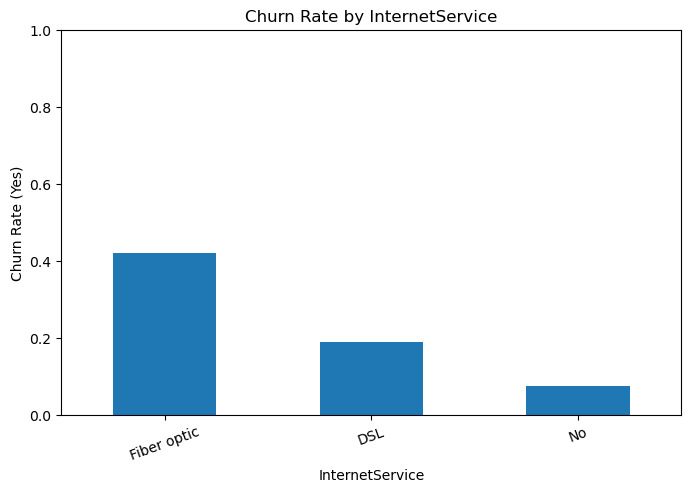

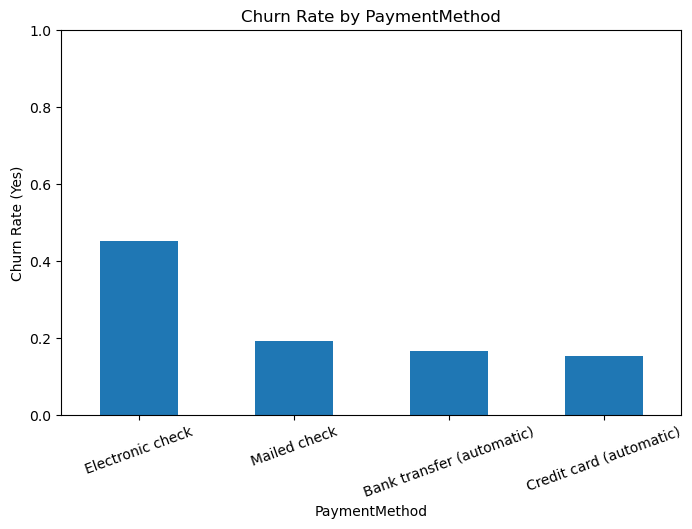

In [11]:
def churn_rate_bar(feature):
    rates = pd.crosstab(df[feature], df["Churn"], normalize="index")["Yes"].sort_values(ascending=False)
    rates.plot(kind="bar")
    plt.title(f"Churn Rate by {feature}")
    plt.xlabel(feature)
    plt.ylabel("Churn Rate (Yes)")
    plt.ylim(0, 1)
    plt.xticks(rotation=20)
    plt.show()

for feat in ["Contract", "InternetService", "PaymentMethod"]:
    churn_rate_bar(feat)


**Interpretation:**
The annotated region indicates a small number of customers with unusually high values
(low frequency in the tail).

These are likely valid premium customers (not data errors), so the outliers are retained.
Removing them may reduce model usefulness because high-paying customers are important
in churn analysis.


In [22]:
Outliers appear in the right tail of charges. In a telco context, high charges can represent
premium customers and are not necessarily incorrect data. Removing them may reduce the model’s
ability to learn churn patterns for high-value customers, so these values are retained.


SyntaxError: invalid character '’' (U+2019) (3173602760.py, line 2)

# 5. Data Preparation for Modelling (no Pipeline)

Steps:
1) Encode target (`Churn`: Yes→1, No→0)  
2) Drop `customerID`  
3) One-hot encode categorical features using `pd.get_dummies()`  
4) Train-test split with `stratify=y` (handles imbalance)  
5) Scale numeric features using `StandardScaler` (fit on train only)


In [12]:
# 5.1 Encode target
df_model = df.copy()
df_model["Churn"] = df_model["Churn"].map({"Yes": 1, "No": 0})

# 5.2 Drop identifier
if "customerID" in df_model.columns:
    df_model = df_model.drop(columns=["customerID"])

# 5.3 Separate features/target
X = df_model.drop(columns=["Churn"])
y = df_model["Churn"]

# 5.4 One-hot encode categoricals (creates a new DataFrame, so we reassign)
X = pd.get_dummies(X, drop_first=True)

print("X shape after encoding:", X.shape)


X shape after encoding: (7043, 30)


In [13]:
# 5.5 Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("Train:", X_train.shape, "Test:", X_test.shape)


Train: (4930, 30) Test: (2113, 30)


Train-test split uses stratification to preserve the churn ratio in both training and test sets,
ensuring evaluation reflects the true class balance.


In [14]:
# 5.6 Scaling numeric features (fit on train, transform train & test)
numeric_cols = [c for c in ["tenure", "MonthlyCharges", "TotalCharges"] if c in X_train.columns]

scaler = StandardScaler()
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train[numeric_cols].describe().T


C:\Users\ahrih\AppData\Local\Temp\ipykernel_35432\2000844340.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-1.11472828 -1.19588443 -1.19588443 ...  1.56342466 -0.34374486
 -1.07415021]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
C:\Users\ahrih\AppData\Local\Temp\ipykernel_35432\2000844340.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.58721331 -0.99299406 -0.50605716 ...  0.10261397 -0.79010368
  1.44169044]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])


,count,mean,std,min,25%,50%,75%,max
tenure,4930.0,1.167423e-16,1.000101,-1.317619,-0.952416,-0.140854,0.954754,1.604003
MonthlyCharges,4930.0,4.143632e-17,1.000101,-1.539324,-0.973859,0.186005,0.830007,1.779062
TotalCharges,4930.0,-1.116979e-17,1.000101,-0.997375,-0.830479,-0.398550,0.677987,2.785321


Categorical features must be converted into numeric form for machine learning algorithms,
so one-hot encoding is used. Numeric scaling is applied because features such as TotalCharges
have larger ranges than tenure, which can bias some models (especially linear models).
Scaling is fitted on the training set only to avoid data leakage.


# 6. Metrics: multiple metrics + model selection justification

Because churn datasets are often imbalanced, accuracy can be misleading.  
We will report:

- **Confusion matrix** (required): counts of TP, FP, TN, FN  
- **Accuracy**: overall correctness  
- **Precision (Churn=Yes)**: of predicted churners, how many truly churn  
- **Recall (Churn=Yes)**: of all true churners, how many we catch  
- **F1-score**: balance between precision and recall  
- **ROC-AUC**: ranking quality across thresholds  
- **PR-AUC**: useful when positive class is smaller

**Primary metric chosen:** **Recall (Churn=Yes)**  
**Reason:** Missing churners (false negatives) leads to lost customers and revenue; catching more churners is the priority for retention targeting.


In [15]:
def evaluate_model(name, model):
    """Train the model and report multiple metrics + confusion matrix."""
    # Train
    model.fit(X_train, y_train)

    # Predict labels
    y_pred = model.predict(X_test)

    # Predict probabilities (for ROC-AUC / PR-AUC)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
    rec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)

    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else np.nan
    pr  = average_precision_score(y_test, y_prob) if y_prob is not None else np.nan

    # Print summary
    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc:.4f}")
    print(f"PR-AUC   : {pr:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=["No", "Yes"], zero_division=0))

    # Confusion matrix plot
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["No", "Yes"]).plot(values_format="d")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    return {
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc,
        "pr_auc": pr
    }


# 7. Modelling (Step-by-step, no Pipeline)

We train multiple models taught in class and compare them using the metrics above.  
A baseline model is included to show improvement over a naive strategy.



=== Baseline (Dummy Most Frequent) ===
Accuracy : 0.7345
Precision: 0.0000
Recall   : 0.0000
F1-score : 0.0000
ROC-AUC  : 0.5000
PR-AUC   : 0.2655

Classification Report:
              precision    recall  f1-score   support

          No       0.73      1.00      0.85      1552
         Yes       0.00      0.00      0.00       561

    accuracy                           0.73      2113
   macro avg       0.37      0.50      0.42      2113
weighted avg       0.54      0.73      0.62      2113



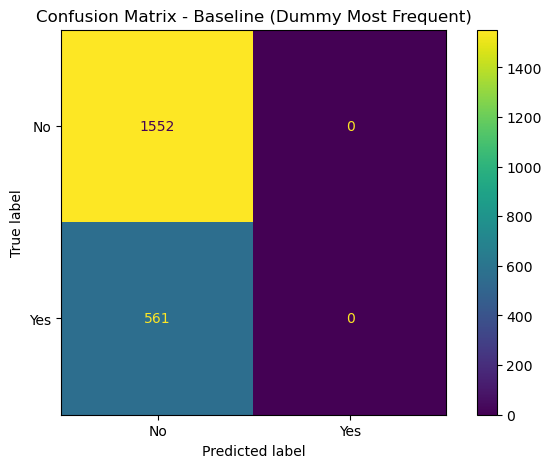


=== Logistic Regression ===
Accuracy : 0.8083
Precision: 0.6660
Recall   : 0.5579
F1-score : 0.6072
ROC-AUC  : 0.8448
PR-AUC   : 0.6420

Classification Report:
              precision    recall  f1-score   support

          No       0.85      0.90      0.87      1552
         Yes       0.67      0.56      0.61       561

    accuracy                           0.81      2113
   macro avg       0.76      0.73      0.74      2113
weighted avg       0.80      0.81      0.80      2113



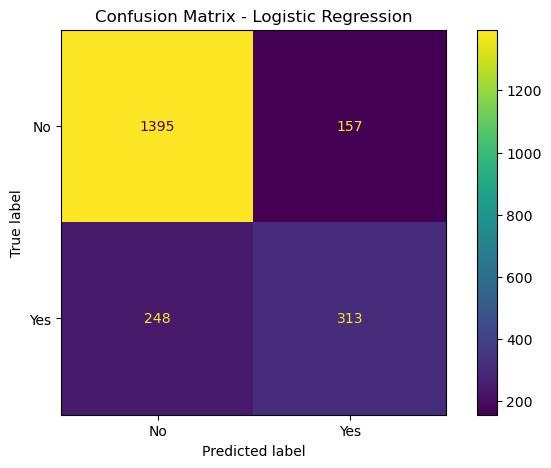


=== Decision Tree ===
Accuracy : 0.7321
Precision: 0.4956
Recall   : 0.4991
F1-score : 0.4973
ROC-AUC  : 0.6581
PR-AUC   : 0.3807

Classification Report:
              precision    recall  f1-score   support

          No       0.82      0.82      0.82      1552
         Yes       0.50      0.50      0.50       561

    accuracy                           0.73      2113
   macro avg       0.66      0.66      0.66      2113
weighted avg       0.73      0.73      0.73      2113



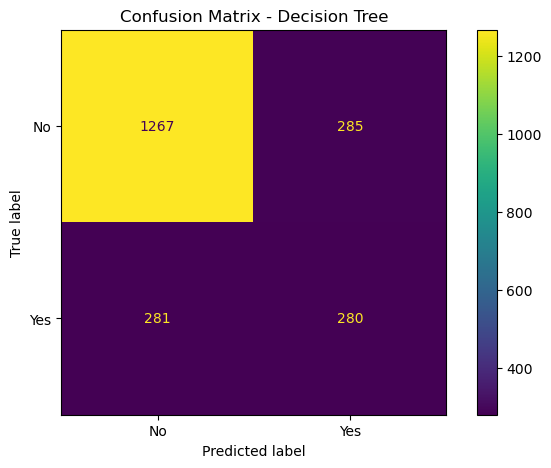


=== Random Forest ===
Accuracy : 0.7856
Precision: 0.6227
Recall   : 0.4884
F1-score : 0.5475
ROC-AUC  : 0.8230
PR-AUC   : 0.6151

Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.89      0.86      1552
         Yes       0.62      0.49      0.55       561

    accuracy                           0.79      2113
   macro avg       0.73      0.69      0.70      2113
weighted avg       0.77      0.79      0.78      2113



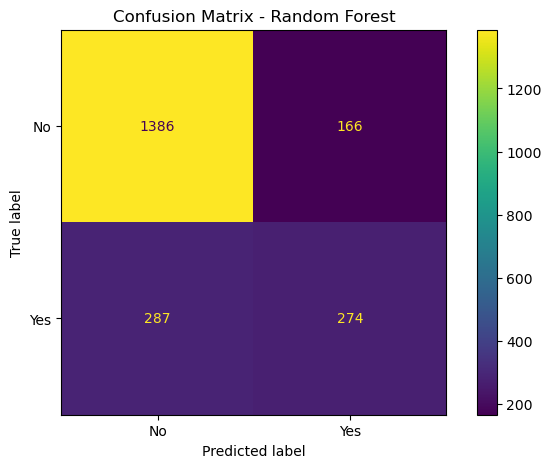


=== Gradient Boosting ===
Accuracy : 0.7960
Precision: 0.6477
Recall   : 0.5080
F1-score : 0.5694
ROC-AUC  : 0.8420
PR-AUC   : 0.6481

Classification Report:
              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1552
         Yes       0.65      0.51      0.57       561

    accuracy                           0.80      2113
   macro avg       0.74      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



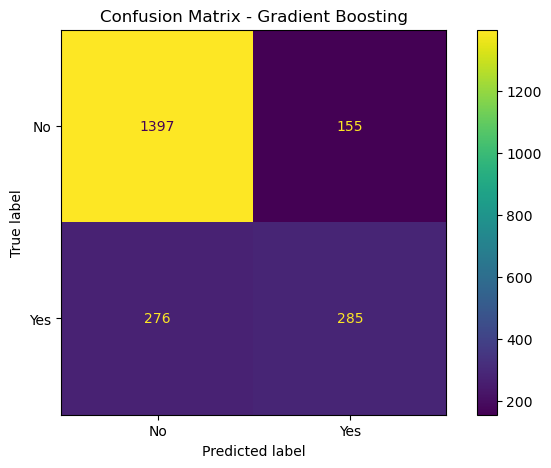

,model,accuracy,precision,recall,f1,roc_auc,pr_auc
1,Logistic Regression,0.808329,0.665957,0.557932,0.607177,0.844763,0.642031
4,Gradient Boosting,0.796025,0.647727,0.508021,0.569431,0.842019,0.648128
2,Decision Tree,0.732134,0.495575,0.499109,0.497336,0.658142,0.380741
3,Random Forest,0.785613,0.622727,0.488414,0.547453,0.823039,0.615140
0,Baseline (Dummy Most Frequent),0.734501,0.000000,0.000000,0.000000,0.500000,0.265499


In [16]:
results = []

# 7.1 Baseline model (most frequent class)
baseline = DummyClassifier(strategy="most_frequent", random_state=42)
results.append(evaluate_model("Baseline (Dummy Most Frequent)", baseline))

# 7.2 Logistic Regression (interpretable baseline model)
lr = LogisticRegression(max_iter=1000, random_state=42)
results.append(evaluate_model("Logistic Regression", lr))

# 7.3 Decision Tree
dt = DecisionTreeClassifier(random_state=42)
results.append(evaluate_model("Decision Tree", dt))

# 7.4 Random Forest (ensemble)
rf = RandomForestClassifier(n_estimators=300, random_state=42)
results.append(evaluate_model("Random Forest", rf))

# 7.5 Gradient Boosting (ensemble boosting)
gb = GradientBoostingClassifier(random_state=42)
results.append(evaluate_model("Gradient Boosting", gb))

results_df = pd.DataFrame(results).sort_values(by="recall", ascending=False)
results_df


## 7.6 Model selection (based on primary metric)

We rank models by **Recall** (primary metric).  
Then we sanity-check Precision and F1 to ensure the model is not triggering too many false positives.

The final model is chosen based on the best trade-off while meeting the business goal (catch churners).

The final model was selected based on the primary metric (Recall for churn=Yes) because the
objective is to identify as many churners as possible. However, precision and F1 were also
checked to ensure the model does not generate too many false alarms. Threshold tuning is
included in deployment to allow the business to adjust the trade-off between recall and precision.



# 8. Hyperparameter Tuning (RandomizedSearchCV)

RandomizedSearchCV is used to tune key hyperparameters (limited values per parameter, as required).  
We tune the most promising model (commonly Random Forest) and use **Recall** as the scoring metric.


In [17]:
# 8.1 Random Forest tuning (example)
param_dist = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 8, 12],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring="recall",
    cv=cv,
    random_state=42,
    n_jobs=1
)

search.fit(X_train, y_train)

print("Best CV Recall:", search.best_score_)
print("Best Params:", search.best_params_)


Best CV Recall: 0.5045684536866426
Best Params: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 12}



=== Random Forest (Tuned) ===
Accuracy : 0.7965
Precision: 0.6541
Recall   : 0.4955
F1-score : 0.5639
ROC-AUC  : 0.8411
PR-AUC   : 0.6512

Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.91      0.87      1552
         Yes       0.65      0.50      0.56       561

    accuracy                           0.80      2113
   macro avg       0.74      0.70      0.72      2113
weighted avg       0.79      0.80      0.79      2113



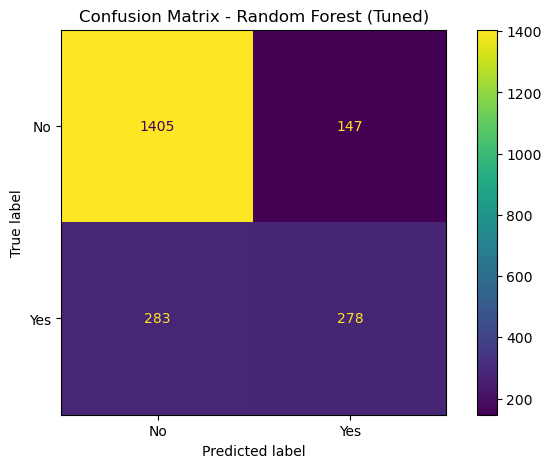

{'model': 'Random Forest (Tuned)',
 'accuracy': 0.79649787032655,
 'precision': 0.6541176470588236,
 'recall': 0.49554367201426025,
 'f1': 0.563894523326572,
 'roc_auc': 0.841079648822978,
 'pr_auc': 0.65120605008716}

In [18]:
# 8.2 Evaluate tuned model on test set
tuned_rf = search.best_estimator_
tuned_result = evaluate_model("Random Forest (Tuned)", tuned_rf)

tuned_result


# 9. Save Model for Deployment (Streamlit)

We save:
- trained model (`telco_churn_model.joblib`)
- scaler (`telco_scaler.joblib`) so the Streamlit app can apply the same scaling


In [19]:
joblib.dump(tuned_rf, "telco_churn_model.joblib")
joblib.dump(scaler, "telco_scaler.joblib")
print("Saved: telco_churn_model.joblib and telco_scaler.joblib")


Saved: telco_churn_model.joblib and telco_scaler.joblib
